# Imports

In [8]:
import gym
import DQNLearner as DQN
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import imp
import torch
import pandas as pd
env = gym.make('LunarLander-v2')

# Plotting Functions

In [2]:
rolling_win = 100
average_scores = []
plots = []
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

num_actions = env.action_space.n
num_states = env.observation_space.shape[0]



def plot_scores(scores,losses,x,y):
    solved = False
    plt.figure(2)
    plt.clf()
    plt.subplot(221)
    plt.title('Training...{}{}'.format(x,y))
    plt.xlabel('100 Episodes')
    plt.ylabel('Average Scores')
    plt.axhline(y=200.0, color='#6435ff',linestyle=':')
    plt.axhline(y=100.0, color='#c935ff',linestyle=':')
    plt.axhline(y=0.0, color='#35a1ff',linestyle='-')
    plt.axhline(y=-100.0, color='#c935ff',linestyle=':')
    plt.axhline(y=-200.0, color='#6435ff',linestyle=':')
    plt.plot(pd.DataFrame(scores).rolling(rolling_win).mean(),c='#ff7f35')
#     if len(scores) > rolling_win:
#         plt.plot(pd.DataFrame(scores).rolling(rolling_win).mean())
    
    
    if len(scores) > 100:
        plt.subplot(223)
        
        plt.axhline(y=200.0, color='#6435ff',linestyle=':')
        plt.axhline(y=100.0, color='#c935ff',linestyle=':')
        plt.axhline(y=0.0, color='#35a1ff',linestyle='-')
        plt.axhline(y=-100.0, color='#c935ff',linestyle=':')
        plt.axhline(y=-200.0, color='#6435ff',linestyle=':')
        plt.plot(scores[-100:],c='#ff7f35')
        plt.axhline(y=np.mean(scores[-100:]), color='#35ff93',linestyle='--')
        
        if np.mean(scores[-100:]) >= 220:
            print("YAY")
            solved = True
    plt.subplot(222)
    if len(losses)> 1000:
        plt.plot(pd.DataFrame(losses).rolling(5000).mean())
    plt.subplot(224)
    plt.plot(losses[-100:])
    
    display.clear_output(wait=True)
    display.display(plt.gcf())
    return solved

def plot_scores_save(scores,x):
    plt.figure(2)
    plt.clf()
    plt.title('Training...{}'.format(x))
    plt.xlabel('100 Episodes')
    plt.ylabel('Average Scores')
    plt.plot(scores)
    avgs = pd.DataFrame(scores).rolling(rolling_win).mean()
    plt.plot(avgs)
    plt.axhline(y=0.0, color='r',linestyle='-')
    plt.axhline(y=-200.0, color='y',linestyle='-')
    plt.axhline(y=-100.0, color='g',linestyle='-')
    plt.savefig('rewards_{}X.png'.format(x))

# Agent Testing Function
### Runs the Agent 100 times and returns the mean score of the 100 trials

In [3]:
def test(learner):
    rewards = []
    for i in range(100):
        reward = 0
        s=torch.tensor(env.reset()).float()
        done = False
        while not done:
            a = torch.tensor(learner.predict(s))
            sprime, r, done, _= env.step(a.item())
            sprime = torch.tensor(sprime).float()
            reward+=r
            r = torch.tensor(r)
            done = torch.tensor(done)
            s=sprime
        rewards.append(reward)

    return np.mean(rewards)


# Agent Training

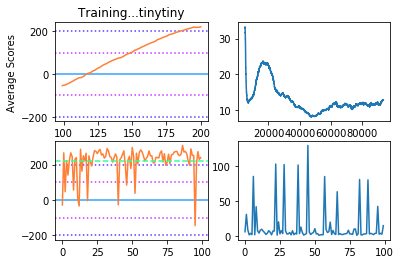

CPU times: user 6min 22s, sys: 23.2 s, total: 6min 45s
Wall time: 6min 49s


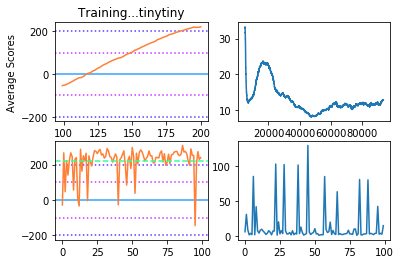

In [4]:
%%time
alpha =.0005
gamma = .99
tau = .9
max_decay = 50
init_eps =1
final_eps =.001

# .0001,.999,.1
average_scores = []
# learner = DQN.DeepQLearner(.0005,.99,1,num_states,num_actions)
learner = DQN.DQNLearner(alpha,gamma,tau,num_states,num_actions,
                         memory_size=5000,
                         batch=64,max_iter=61000,
                         max_decay=max_decay,init_eps=init_eps,
                         final_eps=final_eps,device='cuda')
steps = 800 # Assume 500 steps per episode, then multiply by number of desired episodes
learner.set_eps(1,steps,.01) # .1/500
learner.set_memory(100000,32)
# learner.set_lr_decay(.99999)
actions = []
scores = []
avg_scores = []
print('Starting:')
e = 0
solved = False
loss = []
for i in range(500):
    s = torch.tensor(env.reset()).float()
    done = False
    render = True
    reward = 0
    

    while not done:
#         env.render()
        a = learner.query(s)

        sprime, r, done, _= env.step(a.item())
        sprime = torch.tensor(sprime).float()
        reward+=r
        r = torch.tensor(r)
        done = torch.tensor(done)
#         if done and r > 0:
#             r *= 10
        learner.save_exp(s,a,r,sprime,done)
        if learner.memory.ready():
            learner.learn(s,a,r,sprime,done)
            loss.append(learner.lossval)
            
        s = sprime

    
#     if learner.memory.ready():
    learner.next_epoch()
    # end of episode
    scores.append(reward)
    if e % 100 == 0:
        solved = plot_scores(scores,loss,'tiny','tiny')
    render=False
    e+= 1
    
    if solved:
        break



solved = plot_scores(scores,loss,'tiny','tiny')


# Save the new Agents Data

In [5]:
pd.DataFrame(np.array(scores)).to_csv('./new_scores.data')
torch.save(learner.Q.state_dict(),'./new_finalQ.model')
torch.save(learner.Qprime.state_dict(),'./new_finalQprime.model')

# Agent Test: 
### Scores over 195 are considered solved

In [7]:
print('The agent scored an average of {} over 100 trials.'.format(test(learner)))

241.1670089273284


241.1670089273284